In [1]:
using Plots
include("coevolution_network_base.jl")
using .CoevolutionNetworkBase
using Printf
theme(:dracula)

  5.114413 seconds (1 allocation: 1.766 KiB)


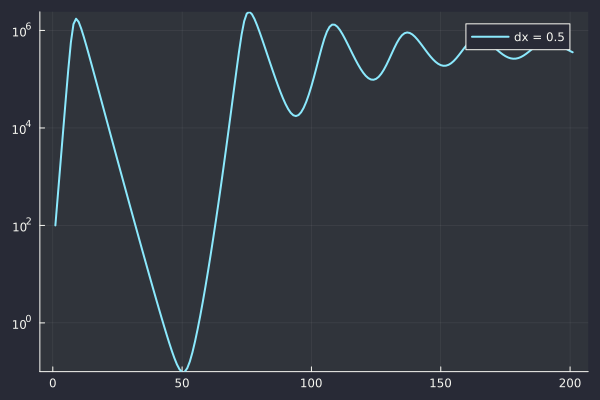

In [18]:
# Parameters
L = 300.0
dx = 0.5
x = -L/2:dx:L/2-dx
r = 5.0
M = 200
beta = 2.0
alpha = 0.0
gamma = 0.5
D = 0.01
Nh = 2 * 10^6
stochastic = false
sigma = 0.1

# Initialize viral and immune densities
viral_density = zeros(Float64, length(x))
viral_density[Int(round(length(x)/2))] = 100/dx

initial_variance = 0.1
# viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
immune_density = zeros(Float64, length(x))

# Create Population instances
population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
populations = [population]

# populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

# Create Network instance
migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
network = Network(populations, migration_matrix);

# Create Simulation instance
dt = 0.01 # Define an appropriate time step size
duration = 200.0 # Define an appropriate simulation duration
simulation = Simulation(network, dt, duration; thin_by=100);

@time run_simulation!(simulation);
GC.gc()

total_infected_per_deme = calculate_total_infected_per_deme(simulation)
plot(total_infected_per_deme[1,:], lw=2, label="dx = $(dx)", yscale=:log10, ylims=(0.1,Inf))

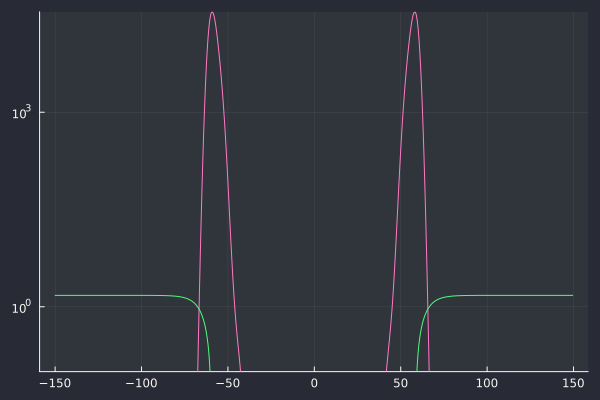

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\Daniel\.julia\packages\Plots\sxUvK\src\utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\Daniel\.julia\packages\Plots\sxUvK\src\utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\Daniel\.julia\packages\Plots\sxUvK\src\utils.jl:106


In [19]:
p = plot(simulation.trajectory[1].populations[1].xs,simulation.trajectory[1].populations[1].viral_density , lw=2, legend=false, yscale=:log10, ylims=(0.1, Inf))

for tidx = length(simulation.trajectory) ÷ 1
    plot!(p,simulation.trajectory[1].populations[1].xs,simulation.trajectory[tidx].populations[1].viral_density)
end
plot!(p,simulation.trajectory[1].populations[1].xs,simulation.trajectory[end].populations[1].fitness)
display(p)

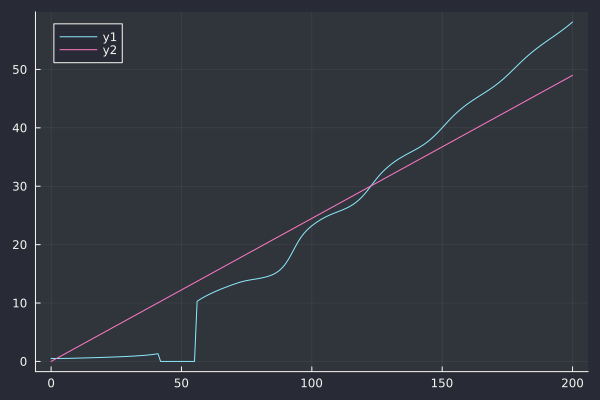

In [20]:
function calculate_mean_absolute_antigenicity_per_deme(simulation::Simulation)
    xs = simulation.trajectory[1].populations[1].xs
    num_time_points = length(simulation.duration_times)
    num_demes = length(simulation.trajectory[1].populations)

    total_infected_per_deme = calculate_total_infected_per_deme(simulation)
    mean_absolute_antigenicity_per_deme = zeros(num_demes, num_time_points)

    for i in 1:num_time_points
        for j in 1:num_demes
            population = simulation.trajectory[i].populations[j]
            if total_infected_per_deme[j, i] > 1
                mean_absolute_antigenicity_per_deme[j, i] = sum(abs.(xs) .* population.viral_density .* population.dx) ./ total_infected_per_deme[j, i]
            else
                mean_absolute_antigenicity_per_deme[j, i] = 0
            end
        end
    end

    return mean_absolute_antigenicity_per_deme
end

mean_abs_antigenicity_per_deme = calculate_mean_absolute_antigenicity_per_deme(simulation)

plot(simulation.duration_times, mean_abs_antigenicity_per_deme[1,:])
plot!(simulation.duration_times, 2 .* sqrt((beta - gamma - alpha) * D) * simulation.duration_times)

In [21]:
anim = Plots.@animate for i in 2:Int(round(length(simulation.duration_times)))
    # Create the primary plot
    p = plot(yscale=:log10, ylims=(1,Nh), xlims=(-L/2, L/2), xlabel="Antigenic Coordinate x", ylabel="Infected Density n(x,t)",background_color=:black)

    # # Plot viral densities on the primary plot
    # reg1 = simulation.trajectory[i].populations[1].viral_density .> 1
    # plot!(p, population.xs[reg1], simulation.trajectory[i].populations[1].viral_density[reg1], linetype=:steppost, label=:none, linewidth=2)
    # Plot viral densities as a histogram
    reg1 = simulation.trajectory[i].populations[1].viral_density .> 1
    temp_dens = simulation.trajectory[i].populations[1].viral_density
    temp_dens[.!reg1] .= NaN
    plot!(p, population.xs, temp_dens, linetype=:steppost, label=:none)


    # Create and update the secondary y-axis for fitnesses
    p3 = twinx(p)
    
    # Separate the label and the time value
    label_str = "Time:"
    time_value_str = @sprintf("%5.1f", simulation.duration_times[i])

    # Annotate the label (fixed position)
    annotate!(p3, 15.5, -0.8, text(label_str, :right, 10, :white))

    # Annotate the time value (positioned next to the label)
    annotate!(p3, 19.0, -0.8, text(time_value_str, :right, 10, :white))




    plot!(p3, ylabel="Fitness F(x)", legend=:none)
    plot!(p3, simulation.trajectory[i].populations[1].xs, simulation.trajectory[i].populations[1].immune_density, ylims=(-1,1.5))
    hline!(p3, [0], linestyle=:dash, color=:white, label=:none)
    
end

mp4(anim, "blah.mp4", fps = 60)

┌ Info: Saved animation to c:\Users\Daniel\Documents\GitHub\viral-coev-net\julia_code\blah.mp4
└ @ Plots C:\Users\Daniel\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\Daniel\\Documents\\GitHub\\viral-coev-net\\julia_code\\blah.mp4")

In [ ]:
Base.summarysize(simulation.cross_reactive_kernel) / 2^20

In [ ]:
Base.summarysize(simulation) / 2^20

In [ ]:
function measure_gc_effect()
    # Measure total memory usage before GC
    memory_before = Sys.free_memory()
    
    # Trigger garbage collection
    GC.gc()
    
    # Measure total memory usage after GC
    memory_after = Sys.free_memory()
    
    # Calculate the difference
    memory_freed = memory_after - memory_before
    
    println("Memory freed by GC: ", memory_freed / 1024^2, " MB")
end

measure_gc_effect()
